In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [139]:
from src.transformers.embedder import Embedder

In [204]:
from src.config import Config
from src.transformers.encoder import Encoder
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.loader_saver import LoaderSaver
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from src.tanimoto import Tanimoto
import torch.nn as nn
from src.analog_discovery.cosine_similarity import CosineSimilarity

## put parameters of the model

In [7]:
config=Config()

In [9]:
config.D_MODEL=512
config.N_LAYERS=5

## params

In [11]:
ls /Users/sebas/projects/data/

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
best_model_20240319_v2_512u_5_layers.ckpt
drug_plus.mgf
drug_plus.pkl
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
merged_gnps_nist_20240319_unique_smiles_1_million_v2.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05

In [88]:
data_folder= '/Users/sebas/projects/data/'
model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'

## load data

In [65]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [66]:
all_spectrums_janssen = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

  0%|                                                                                                                                                                                                                           | 2033/100000000 [00:01<18:38:49, 1489.63it/s]


We reached the end of the array at index 2033


## Open model

In [89]:
model = Embedder.load_from_checkpoint(
        model_path,
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
        use_cosine_distance=config.use_cosine_distance,
    )

Using cosine library from Pytorch?: True


## get the encoder

In [141]:
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))

Using cosine library from Pytorch?: True


In [142]:
encoder.model

SpectrumTransformerEncoderCustom(
  (peak_encoder): PeakEncoder(
    (mz_encoder): FloatEncoder()
    (int_encoder): FloatEncoder()
    (combiner): Linear(in_features=1024, out_features=512, bias=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-4): 5 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [116]:
batch= {'mz':np.zeros((1, 100), dtype=np.float32),
        'intensity':np.zeros((1, 100), dtype=np.float32),
        'precursor_mass': np.zeros((1, 1), dtype=np.float32),
        'precursor_charge': np.zeros((1, 1), dtype=np.float32),
       }

In [117]:
batch= {k:torch.tensor(batch[k]) for k in batch}

In [118]:
embedding=encoder.forward(batch)

/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())


In [119]:
embedding.detach().numpy()[0].shape

(512,)

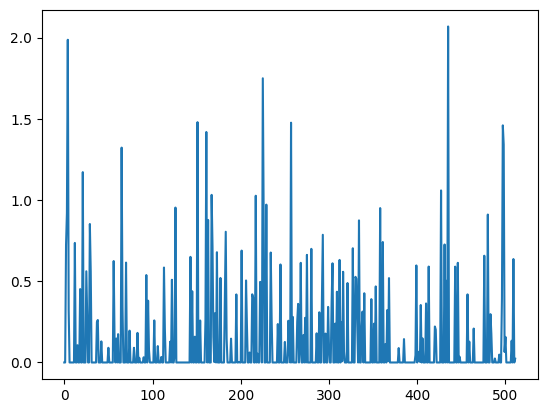

In [120]:
plt.plot(embedding.detach().numpy()[0][0:1000])

## run the forward pass on the spectrums

In [121]:
dataset_spectrums= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen)

Preprocessing all the data ...


2033it [00:00, 66541.96it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [122]:
dataloader_spectrums= DataLoader(dataset_spectrums, batch_size=config.BATCH_SIZE,  num_workers=0
)

In [123]:
predictor = pl.Trainer(max_epochs=0, enable_progress_bar=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [124]:
embeddings = predictor.predict(
    encoder,
    dataloader_spectrums,
)

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [143]:
embeddings = encoder.get_embeddings(dataloader_spectrums)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [162]:
results = [{'spectrum':s, 
            'smiles': s.smiles,
            'params':s.params,
            'embedding':emb} for s,emb in zip(all_spectrums_janssen, embeddings)]

## check results for 2 embeddings

In [197]:
target_index_0=100
target_index_1=99

In [198]:
# compute tanimoto
tanimoto =Tanimoto.compute_tanimoto_from_smiles(results[target_index_0]['smiles'], results[target_index_1]['smiles'])
tanimoto

0.3916967509025271

In [200]:
def cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two vectors.

    Parameters:
    vec1 (numpy.ndarray): First vector.
    vec2 (numpy.ndarray): Second vector.

    Returns:
    float: Cosine similarity between the two vectors.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

In [202]:
nn.CosineSimilarity(dim=1)(torch.tensor(results[target_index_0]['embedding'].reshape(1,-1)),
                           torch.tensor(results[target_index_1]['embedding'].reshape(1,-1)))

tensor([0.3503])

In [203]:
cosine_similarity(torch.tensor(results[target_index_0]['embedding'].reshape(-1)),torch.tensor(results[target_index_1]['embedding'].reshape(-1)) )

0.35034952

In [210]:
results_analog_discovery= CosineSimilarity.batch_cosine_similarity_combinations(embeddings, embeddings)

In [213]:
results_analog_discovery

array([[0.9999998 , 0.3410519 , 0.38750446, ..., 0.45864475, 0.44836602,
        0.20981684],
       [0.3410519 , 1.0000002 , 0.5627128 , ..., 0.5022747 , 0.5075601 ,
        0.28704005],
       [0.38750446, 0.5627128 , 1.0000002 , ..., 0.5405134 , 0.55961424,
        0.31479806],
       ...,
       [0.45864475, 0.5022747 , 0.5405134 , ..., 0.9999999 , 0.9087073 ,
        0.40602466],
       [0.44836602, 0.5075601 , 0.55961424, ..., 0.9087073 , 1.        ,
        0.3990823 ],
       [0.20981684, 0.28704005, 0.31479806, ..., 0.40602466, 0.3990823 ,
        0.99999994]], dtype=float32)

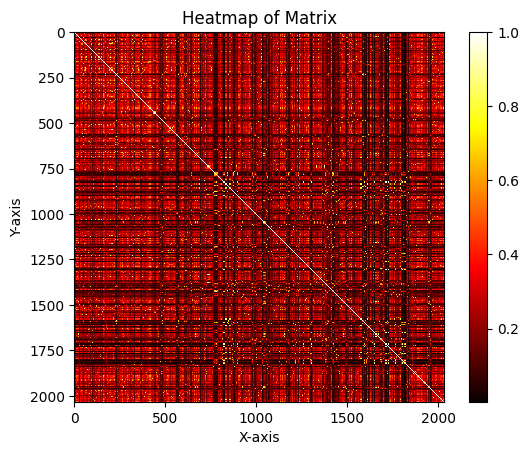

In [214]:
plt.imshow(results_analog_discovery, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add colorbar to show scale
plt.title('Heatmap of Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
